In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
log_name = "IF_track_20200315.txt"
with open(log_name, "r") as f:
    lines = f.readlines()

lines = [l.strip() for l in lines]

### RX fine codes vs. temperature

The temperature represents when the RX fine code was bumped up to that value while sweeping the temperature.

In [3]:
fine_codes_vs_temp = {
    2: 17.5,
    9: 19.2,
    10: 19.5,
    11: 20,
    12: 20.6,
    13: 20.9,
    14: 21.1,
    15: 21.9,
    17: 22.3,
    18: 22.7,
    19: 23.1,
    20: 23.6,
    22: 24.8,
    23: 25.6,
    24: 26.5,
    26: 27.5,
    27: 28.2,
    28: 29.5,
    29: 30.1
}

fine_codes = list(fine_codes_vs_temp.keys())
temp = list(fine_codes_vs_temp.values())

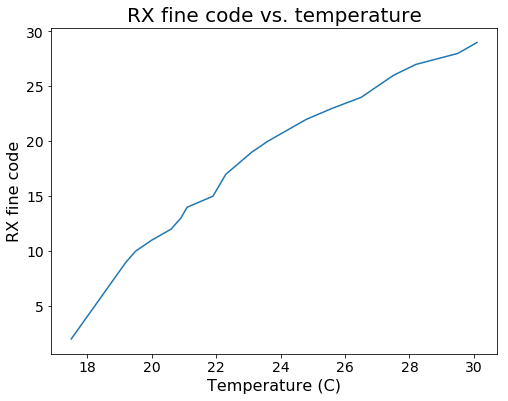

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(temp, fine_codes)
plt.xlabel("Temperature (C)", fontsize=16)
plt.ylabel("RX fine code", fontsize=16)
plt.title("RX fine code vs. temperature", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Filtered IF offset and TX/RX fine codes vs. time

The temperature ramp rate was 1.5C/min.

In [5]:
# Every 800ms, a line with "RX fine: %d, TX fine: %d" is printed.
time_delta = 0.8 # 800ms

match_template = r"RX fine: (\d+), TX fine: (\d+)"
IF_template = r"IF offset: (-?\d+), previous IF offset: (-?\d+)"

In [6]:
# Two separate time arrays since IF offset is not always printed.
time_fine, RX_fine, TX_fine = [], [], []
time_IF, IF_offset = [], []

t = 0
for line in lines:
    match = re.search(match_template, line)
    if match is not None:
        time_fine.append(t)
        
        rx, tx = match.groups()
        RX_fine.append(int(rx))
        TX_fine.append(int(tx))
        
        IF_match = re.search(IF_template, line)
        if IF_match is not None:
            time_IF.append(t)
            
            offset, prev_offset = IF_match.groups()
            IF_offset.append(int(offset))
        
        t += time_delta

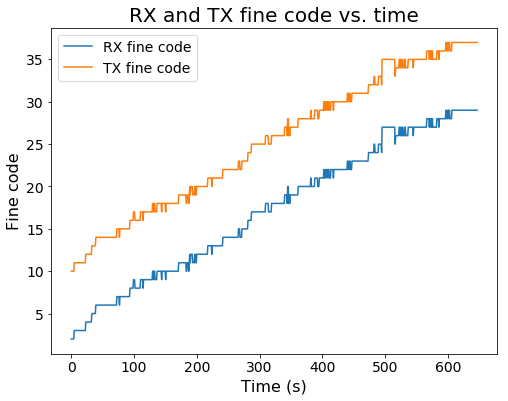

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(time_fine, RX_fine, label="RX fine code")
plt.plot(time_fine, TX_fine, label="TX fine code")
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Fine code", fontsize=16)
plt.title("RX and TX fine code vs. time", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

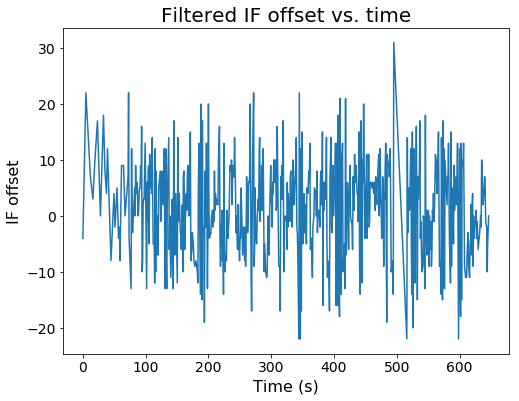

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(time_IF, IF_offset)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("IF offset", fontsize=16)
plt.title("Filtered IF offset vs. time", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()